In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib.pyplot as plt 
#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

from torch.optim import Adam
from tqdm import tqdm


from sklearn.model_selection import train_test_split
#GPU 사용 시
device = torch.device("cuda:0")

In [3]:
import random

SEED  = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
from sklearn.metrics import *

In [5]:
from transformers import ElectraModel
from transformers import ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

example_text = 'I will watch Memento tonight'
Electra_input = tokenizer(example_text,padding='max_length', max_length = 256, 
                       truncation=True, return_tensors="pt")

In [6]:
# 데이터를 각각 목적에 맞게 나누기
train_data = pd.read_excel('Dataset/Training.xlsx')
original_valid_data = pd.read_excel('Dataset/Validation.xlsx')

valid_data, test_data = train_test_split(original_valid_data,test_size=0.5, random_state=42, shuffle =True)

In [7]:
labels = {
    "기쁨":0,
    "기쁨 ":0,
    "불안":1,
    "불안 ":1,
    "분노":2,
    "당황":3,
    "슬픔":4,
    "상처":5
}

In [8]:
class ElectraDataset(Dataset):
    def __init__(self,df):
        self.labels = [labels[label] for label in df['감정_대분류']]
        self.texts = [tokenizer(str(sentence), padding = "max_length", max_length=128, truncation=True, return_tensors='pt') for sentence in df['사람문장1']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [11]:
class HierachicalClassifier(nn.Module):
    def __init__(self,dropout=0.5):
        super(HierachicalClassifier, self).__init__()
        self.Electra1  = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
        self.Electra2  = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)
        self.booleanlinear = nn.Linear(768,2)
        self.multilinear = nn.Linear(100,5)
        self.testlinear = nn.Linear(768,100)
        self.relu = nn.ReLU()
    

    def forward(self, input_id, mask):
        multi_idx = []
        boolean_idx = []
        
        pooled_output = self.Electra1(input_ids=input_id, attention_mask=mask, return_dict = False)
        x = self.dropout(pooled_output[0][:,0,:])
        x = self.booleanlinear(x)
        x = self.softmax(x)
        predict_x = x.argmax(dim=1).tolist()
        
        for i in range(len(predict_x)):
            if predict_x[i] == 1:
                multi_idx.append(i)
            elif predict_x[i] == 0: 
                boolean_idx.append(i) 

        if len(multi_idx)!=0:
            multi_x = self.testlinear(pooled_output[0][multi_idx,0,:])
            multi_x = self.dropout(multi_x)
            multi_x = self.relu(multi_x)
            multi_x = self.multilinear(multi_x)
            multi_x = self.softmax(multi_x)

        concat_x = []
            
        binary,multiple = 0,0 
        for i in range(len(predict_x)):
            if i in boolean_idx:
                concat_x.append(x[binary])
                binary = binary+1
            if i in multi_idx:
                concat_x.append(multi_x[multiple])
                multiple = multiple+1
        return concat_x

In [12]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = ElectraDataset(train_data), ElectraDataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=32)
    
    use_cuda = torch.cuda.is_available()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate, weight_decay=0.05)    
    
    if use_cuda:
            criterion = criterion.cuda()

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
  
    for epoch_num in range(epochs):
        model.train()
        total_acc_train = 0
        total_loss_train = 0
        for train_input, train_label in tqdm(train_dataloader):
            
            bool_batch_loss = 0
            multi_batch_loss = 0 
            
            bool_batch_acc = 0
            multi_batch_acc = 0
            
            optimizer.zero_grad()
            
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            model.to(device)

            output = model(input_id, mask)
            # output = output_.data.cpu().numpy()
            if len(output) == 0 : continue
            
            for i in range(len(output)):
                if output[i].shape == torch.Size([2]): 
                    if train_label[i].item() >= 1:  
                        temp = torch.LongTensor([1.]).to(device)
                    else: temp = torch.LongTensor([0.]).to(device)
                    
                    bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()
                    bool_batch_acc += bool_acc
                    bool_batch_loss += criterion(output[i].unsqueeze(0),temp) 

                elif output[i].shape == torch.Size([5]): 
                    if train_label[i] == 0: 
                      temp = torch.LongTensor([(train_label[i]).long()]).to(device)
                    else: temp = torch.LongTensor([(train_label[i]-1).long()]).to(device)  
                    multi_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()
                    multi_batch_acc += multi_acc
                    multi_batch_loss += criterion(output[i].unsqueeze(0), temp)
            
            batch_loss = bool_batch_loss + multi_batch_loss
            batch_acc = bool_batch_acc + multi_batch_acc
            
            total_loss_train += batch_loss
            total_acc_train += batch_acc
            
            model.zero_grad()
            
            if bool_batch_loss == 0: multi_batch_loss.backward()
            elif multi_batch_loss == 0: bool_batch_loss.backward()
            else: batch_loss.backward()
            
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        model.eval()
        with torch.no_grad():
          for val_input, val_label in val_dataloader:

            val_bool_batch_loss = 0
            val_multi_batch_loss = 0 
            
            val_bool_batch_acc = 0
            val_multi_batch_acc = 0
            
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            
            output = model(input_id, mask)

            if len(output) == 0 : continue
            for i in range(len(output)):
                if output[i].shape == torch.Size([2]):
                    if val_label[i].item() >= 1:
                        temp = torch.LongTensor([1.]).to(device)
                    else:
                        temp = torch.LongTensor([0.]).to(device)
                        
                    bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()
                    val_bool_batch_acc += bool_acc
                    val_bool_batch_loss += criterion(output[i].unsqueeze(0),temp)
                elif output[i].shape == torch.Size([5]):
                    if val_label[i] == 0:
                      temp = torch.LongTensor([(val_label[i]).long()]).to(device)
                    else: temp = torch.LongTensor([(val_label[i]-1).long()]).to(device)
                    multi_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()
                    val_multi_batch_acc += multi_acc
                    val_multi_batch_loss += criterion(output[i].unsqueeze(0), temp)
                    
            batch_loss = val_bool_batch_loss + val_multi_batch_loss
            batch_acc = val_bool_batch_acc + val_multi_batch_acc
            
            total_loss_val += batch_loss
            total_acc_val += batch_acc
            
        
        print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}') 

        total_loss_train2 = total_loss_train.cpu()/ len(train_data)
        total_acc_train2 = total_acc_train / len(train_data)
        total_loss_val2 = total_loss_val.cpu()/ len(val_data)
        total_acc_val2 = total_acc_val / len(val_data)

        train_loss_list.append(total_loss_train2.detach().numpy())
        train_acc_list.append(total_acc_train2)

        val_acc_list.append(total_acc_val2)
        val_loss_list.append(total_loss_val2.detach().numpy())  

    epochs = np.arange(1,epochs+1) 
    plt.figure(figsize=(10,5))
    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Train_Loss')
    plt.plot(epochs, train_loss_list)
    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Train_Accuracy')
    plt.plot(epochs, train_acc_list)

    plt.figure(figsize=(10,5))
    plt.subplot(2,2,3)
    plt.xlabel('Epoch')
    plt.ylabel('Valid_Loss')
    plt.plot(epochs, val_loss_list)
    plt.subplot(2,2,4)
    plt.xlabel('Epoch')
    plt.ylabel('Valid_Accuracy')
    plt.plot(epochs, val_acc_list)

    plt.show()     

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discrim

Epochs: 1 | Train Loss:  1.493                 | Train Accuracy:  0.385                 | Val Loss:  1.316                 | Val Accuracy:  0.621


100%|██████████| 1614/1614 [07:55<00:00,  3.39it/s]


Epochs: 2 | Train Loss:  1.371                 | Train Accuracy:  0.543                 | Val Loss:  1.237                 | Val Accuracy:  0.666


100%|██████████| 1614/1614 [07:58<00:00,  3.37it/s]


Epochs: 3 | Train Loss:  1.340                 | Train Accuracy:  0.562                 | Val Loss:  1.239                 | Val Accuracy:  0.659


100%|██████████| 1614/1614 [07:49<00:00,  3.44it/s]


Epochs: 4 | Train Loss:  1.334                 | Train Accuracy:  0.567                 | Val Loss:  1.246                 | Val Accuracy:  0.654


100%|██████████| 1614/1614 [07:50<00:00,  3.43it/s]


Epochs: 5 | Train Loss:  1.335                 | Train Accuracy:  0.565                 | Val Loss:  1.233                 | Val Accuracy:  0.664


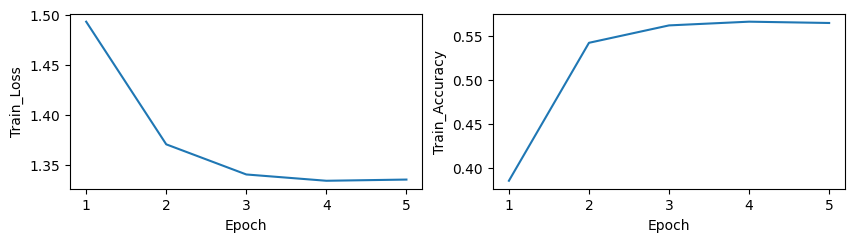

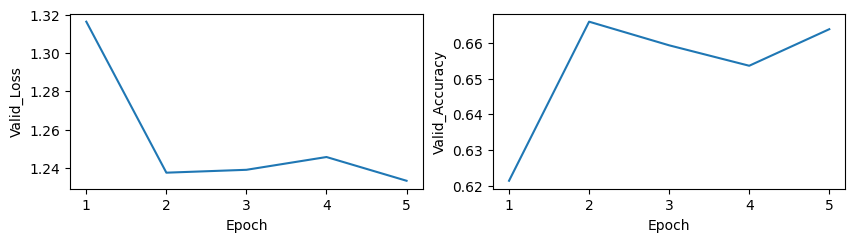

In [13]:
EPOCHS = 5
model =HierachicalClassifier()
LR = 1e-5
torch.cuda.empty_cache()
train(model, train_data, valid_data, LR, EPOCHS)

In [14]:
def evaluate(model, test_data):
    
    test = ElectraDataset(test_data)
    
    test_dataloader = torch.utils.data.DataLoader(test,batch_size=2)


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
 
    if use_cuda:
            criterion = criterion.cuda()
    
    total_acc_test =0

    total_output = []
    total_label = []

    total_loss_test = 0 
    total_acc_test = 0
    with torch.no_grad():
      for test_input, test_label in test_dataloader:            
          test_label = test_label.to(device)
          test_label_list = test_label.tolist()
                    
          mask = test_input['attention_mask'].to(device)
          input_id = test_input['input_ids'].squeeze(1).to(device)

          output= model(input_id, mask)

          if len(output) == 0 : continue
          for i in range(len(output)):
            test_bool_batch_loss = 0
            test_multi_batch_loss = 0 
            
            test_bool_batch_acc = 0
            test_multi_batch_acc = 0

            if output[i].shape == torch.Size([2]): 
                  if test_label[i].item() >= 1: 
                      temp = torch.LongTensor([1.]).to(device)
                      
                      bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()

                      output_cpu = (output[i].unsqueeze(0).argmax(dim=1)).cpu().tolist()
                      total_output += output_cpu

                      temp_cp = torch.LongTensor([(test_label[i]).long()]).to(device).tolist()
                      total_label+= temp_cp

                      test_bool_batch_acc += bool_acc
                      test_bool_batch_loss += criterion(output[i].unsqueeze(0),temp)

                  else:
                      temp = torch.LongTensor([0.]).to(device)
                      
                      bool_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()

                      output_cpu = output[i].unsqueeze(0).argmax(dim=1).cpu().tolist()
                      total_output += output_cpu

                      temp_cp = temp.cpu().tolist()
                      total_label+= temp_cp

                      test_bool_batch_acc += bool_acc
                      test_bool_batch_loss += criterion(output[i].unsqueeze(0),temp)

            elif output[i].shape == torch.Size([5]):
                  if test_label[i] == 0:
                    temp = torch.LongTensor([(test_label[i]).long()]).to(device)        
                    temp_cp = temp.cpu().tolist()
                    output_cpu = (output[i].unsqueeze(0).argmax(dim=1)).cpu().tolist()
                    total_output += output_cpu

                  else:
                    temp = torch.LongTensor([(test_label[i]-1).long()]).to(device) # -1
                    temp_cp = (temp+1).cpu().tolist() # +1
                    output_cpu = (output[i].unsqueeze(0).argmax(dim=1)+1).cpu().tolist()
                    total_output += output_cpu
                  total_label+= temp_cp

                  multi_acc = (output[i].unsqueeze(0).argmax(dim=1) == temp).sum().item()
                  test_multi_batch_acc += multi_acc
                  test_multi_batch_loss += criterion(output[i].unsqueeze(0), temp)
                    
          batch_loss = test_bool_batch_loss + test_multi_batch_loss
          batch_acc = test_bool_batch_acc + test_multi_batch_acc
            
          total_loss_test += batch_loss
          total_acc_test += batch_acc

    print(classification_report(total_label,total_output))

'\ndef evaluate(model, test_data):\n    \n    test = ElectraDataset(test_data)\n    \n    test_dataloader = torch.utils.data.DataLoader(test,batch_size=2)\n\n\n    use_cuda = torch.cuda.is_available()\n    device = torch.device("cuda" if use_cuda else "cpu")\n\n    criterion = nn.CrossEntropyLoss()\n \n    if use_cuda:\n            criterion = criterion.cuda()\n    \n    total_acc_test =0\n\n    total_output = []\n    total_label = []\n\n    total_loss_test = 0 \n    total_acc_test = 0\n    with torch.no_grad():\n      for test_input, test_label in test_dataloader:            \n          test_label = test_label.to(device)\n          test_label_list = test_label.tolist()\n        \n                  \n          mask = test_input[\'attention_mask\'].to(device)\n          input_id = test_input[\'input_ids\'].squeeze(1).to(device)\n\n          output= model(input_id, mask)\n\n\n          if len(output) == 0 : continue\n          for i in range(len(output)):\n            test_bool_batch_los

In [15]:
import time

global total_acc_test

start_time = time.time()
evaluate(model,test_data)
print("---{}s seconds---".format(time.time()-start_time))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       574
           1       0.62      0.67      0.64       548
           2       0.65      0.71      0.68       624
           3       0.71      0.46      0.56       538
           4       0.53      0.69      0.60       522
           5       0.54      0.56      0.55       515

    accuracy                           0.66      3321
   macro avg       0.67      0.66      0.66      3321
weighted avg       0.68      0.66      0.66      3321

---21.60553789138794s seconds---
